# 目的
遺伝子学的分類に基づいた、再発の2値分類を実施する。  

In [6]:
import os
import random
import itertools

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from tqdm import tqdm
import warnings

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

# models
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析
from lightgbm import LGBMClassifier
import xgboost as xgb

from sklearn.ensemble import ExtraTreesClassifier

# 学習中
from sklearn.model_selection import learning_curve, cross_validate, cross_val_score

# 評価指標
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# local libraries
import config
import functions

SEED = config.SEED
functions.fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_recurrenced.pkl"
)

# データ全体での予測モデル検証

## ベースモデルの学習結果

各特徴量選択されたdfを用いて基本的な2値分類モデルを学習する

0it [00:00, ?it/s]

--------------------------------------------------
subgroup column:  CLAUDIN_SUBTYPE
..................................................
subgroup:  LumA
./../data/interim/PREPROCESSED/RECURRENCE/CROSS/CLAUDIN_SUBTYPE/mrmr_std_smote
(192, 17) (20, 17)
base accuracy:  0.5


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
DecisionTreeClassifier,0.755208,0.60,0.758974,0.666667
QuadraticDiscriminantAnalysis,0.927083,0.35,0.927835,0.434783
SGDClassifier,0.854167,0.35,0.857143,0.434783
GaussianNB,0.869792,0.35,0.867725,0.380952
LogisticRegression,0.885417,0.35,0.885417,0.380952
RandomForestClassifier,0.932292,0.35,0.932642,0.380952
SVC,0.927083,0.35,0.927628,0.380952
KNeighborsClassifier,0.869792,0.30,0.858757,0.363636
GradientBoostingClassifier,1.000000,0.35,1.000000,0.315789


(192, 17) (20, 17)
base accuracy:  0.5


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
LGBMClassifier,1.0,0.35,1.0,0.380952


(192, 17) (20, 17)
base accuracy:  0.5


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
ExtraTreesClassifier,1.0,0.4,1.0,0.454545


1it [00:02,  2.85s/it]


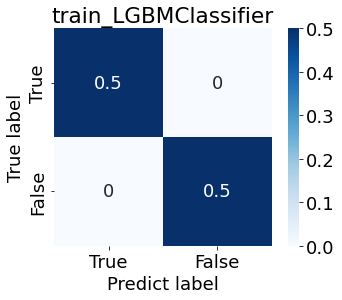

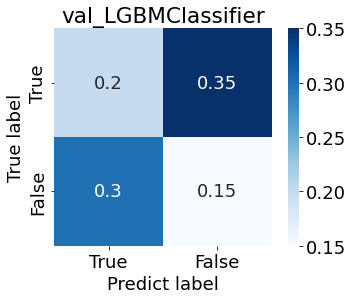

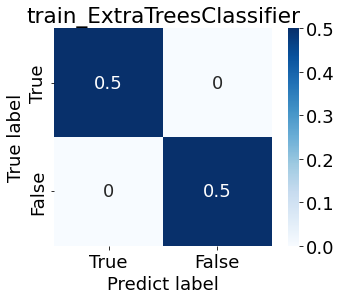

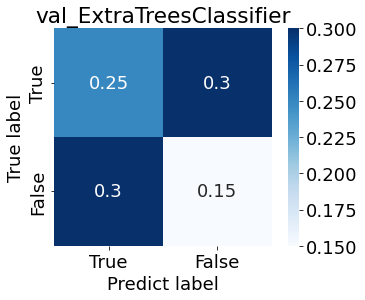

In [7]:
def validate_models(
    input_file_path: str = None,
    input_file_name: str = None,
    classifiers: list = config.classifiers,
    plot: bool = False,
):
    try:
        list_train, list_val, _, _ = functions.read_preprocessed_df(
            input_file_path, input_file_name
        )
    except:
        return
    X_train, y_train = list_train[0], list_train[1]
    X_val, y_val = list_val[0], list_val[1]
    print(X_train.shape, X_val.shape)

    # accuracyの表示
    print("base accuracy: ", (y_train == 1).sum() / y_train.shape[0])
    # print("使用特徴量：", X_train.columns)
    # print("train shape: ", X_train.shape, y_train.shape)
    # print("val shape: ", X_val.shape, y_val.shape)
    # print("value_counts: ", y_train.value_counts(), y_val.value_counts())
    display(
        functions.compare_bcms(
            X_train,
            y_train,
            X_val,
            y_val,
            classifiers=classifiers,
            plot=plot,
        )
    )


# サブグループ削除（一時的に）
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "NPI_CAT",
    # "TUMOR_CAT",
    # "LYMPH_CAT",
]

feature_selection_methods = [
    # "variance_threshold",
    "mrmr"
]

scaling_methods = [
    "std",
    # "norm"
]

sampling_methods = [
    # "none",
    "smote"
]

for feature_selection_method, scaling_method, sampling_method in tqdm(
    itertools.product(feature_selection_methods, scaling_methods, sampling_methods)
):
    preprocess_order = "{0}_{1}_{2}".format(
        feature_selection_method, scaling_method, sampling_method
    )
    print("=====" * 10)
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("-----" * 10)
        print("subgroup column: ", subgroup_column)

        # for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
        for subgroup in ["LumA"]:  # サブグループ毎への適用
            print("....." * 10)
            print("subgroup: ", subgroup)
            input_file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
                subgroup_column,
                preprocess_order,
                plot=True,
            )
            print(input_file_path)
            validate_models(
                input_file_path=input_file_path, input_file_name=subgroup, plot=False
            )

            params = {
                "class_weight": "balanced",
                "random_state": SEED,
            }
            validate_models(
                input_file_path=input_file_path,
                input_file_name=subgroup,
                classifiers=[LGBMClassifier(**params)],
                plot=True,
            )

            params = {
                "class_weight": "balanced",
                "random_state": SEED,
            }
            validate_models(
                input_file_path=input_file_path,
                input_file_name=subgroup,
                classifiers=[ExtraTreesClassifier(**params)],
                plot=True,
            )

## xgboost

In [3]:
# サブグループ削除（一時的に）
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "NPI_CAT",
    # "TUMOR_CAT",
    # "LYMPH_CAT",
]

feature_selection_methods = [
    "variance_threshold",
    # "mrmr"
]


scaling_methods = [
    "std",
    # "norm"
]


for feature_selection_method, scaling_method in tqdm(
    itertools.product(feature_selection_methods, scaling_methods)
):
    print("=====" * 10)
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("-----" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            print("....." * 10)
            print("subgroup: ", subgroup)
            file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
                subgroup_column,
                feature_selection_method,
                scaling_method,
            )
            file_name = subgroup

            try:
                list_train, list_val, _, _ = functions.read_preprocessed_df(
                    file_path, file_name
                )
            except:
                continue

            X_train, y_train = list_train[0], list_train[1].map(lambda x: int(x))
            X_val, y_val = list_val[0], list_val[1].map(lambda x: int(x))

            # scaling
            X_train, X_val = functions.transform_std(X_train, X_val)
            sm = SMOTE(random_state=SEED)
            X_train, y_train = sm.fit_resample(X_train, y_train)

            xgb_train = xgb.DMatrix(
                X_train, label=y_train, feature_names=X_train.columns
            )
            xgb_val = xgb.DMatrix(X_val, label=y_val, feature_names=X_val.columns)

            param = {
                # 二値分類問題
                "objective": "binary:logistic",
            }
            clf = xgb.train(param, xgb_train)
            y_val_pred_proba = clf.predict(xgb_val)
            y_val_pred = np.where(y_val_pred_proba > 0.5, 1, 0)
            functions.show_scores(y_val, y_val_pred)

1it [00:00, 306.02it/s]

--------------------------------------------------
subgroup column:  CLAUDIN_SUBTYPE
..................................................
subgroup:  LumB
pkl file does not exist
..................................................
subgroup:  Her2
pkl file does not exist
..................................................
subgroup:  LumA
pkl file does not exist
..................................................
subgroup:  claudin-low
pkl file does not exist
..................................................
subgroup:  Basal
pkl file does not exist
..................................................
subgroup:  Normal
pkl file does not exist
..................................................
subgroup:  NC
pkl file does not exist
